In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import xgboost as xgb 
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import uniform,randint
from xgboost import plot_importance

In [10]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [12]:
path = r'res2.csv';

In [13]:
ori = pd.read_csv(path);
print(ori.head())
ori = pd.DataFrame(ori)
ori['Order Date'] = pd.to_datetime(ori['Order Date'] ,dayfirst=True)
ori['Order Date'] = ori['Order Date'].dt.date

   Order ID        Order Date             Item Name  Quantity  Product Price  Total products
0     25583  03/08/2019 21:58  Tandoori Mixed Grill         1          11.95              12
1     25583  03/08/2019 21:58          Madras Sauce         1           3.95              12
2     25583  03/08/2019 21:58         Mushroom Rice         2           3.95              12
3     25583  03/08/2019 21:58           Garlic Naan         1           2.95              12
4     25583  03/08/2019 21:58               Paratha         1           2.95              12


In [14]:
print(ori.head())
print(f"Total number of orders in dataset: {ori['Order ID'].nunique()}")
print(ori.shape)

   Order ID  Order Date             Item Name  Quantity  Product Price  Total products
0     25583  2019-08-03  Tandoori Mixed Grill         1          11.95              12
1     25583  2019-08-03          Madras Sauce         1           3.95              12
2     25583  2019-08-03         Mushroom Rice         2           3.95              12
3     25583  2019-08-03           Garlic Naan         1           2.95              12
4     25583  2019-08-03               Paratha         1           2.95              12
Total number of orders in dataset: 19658
(119183, 6)


In [15]:
ori.columns = ['Order_ID', 'Date', 'item', 'quantity', 'price', 'total_products_in_cart']
print(ori.head())

   Order_ID        Date                  item  quantity  price  total_products_in_cart
0     25583  2019-08-03  Tandoori Mixed Grill         1  11.95                      12
1     25583  2019-08-03          Madras Sauce         1   3.95                      12
2     25583  2019-08-03         Mushroom Rice         2   3.95                      12
3     25583  2019-08-03           Garlic Naan         1   2.95                      12
4     25583  2019-08-03               Paratha         1   2.95                      12


In [16]:
from pandasql import sqldf
pysqldf = lambda q : sqldf(q,globals());

In [17]:
def load_q(path):
    with open(path) as file:
        return file.read();

In [18]:
pathq = r'C:\Users\LENOVO\Desktop\ques\t2Daily.sql'    
query = load_q(pathq);
DailyOrders = pysqldf(query);
DailyOrders = pd.DataFrame(DailyOrders);

In [19]:
print(DailyOrders.head());

         date  total_number
0  2015-12-16             1
1  2016-05-27            17
2  2016-05-28            30
3  2016-05-29            21
4  2016-05-30            18


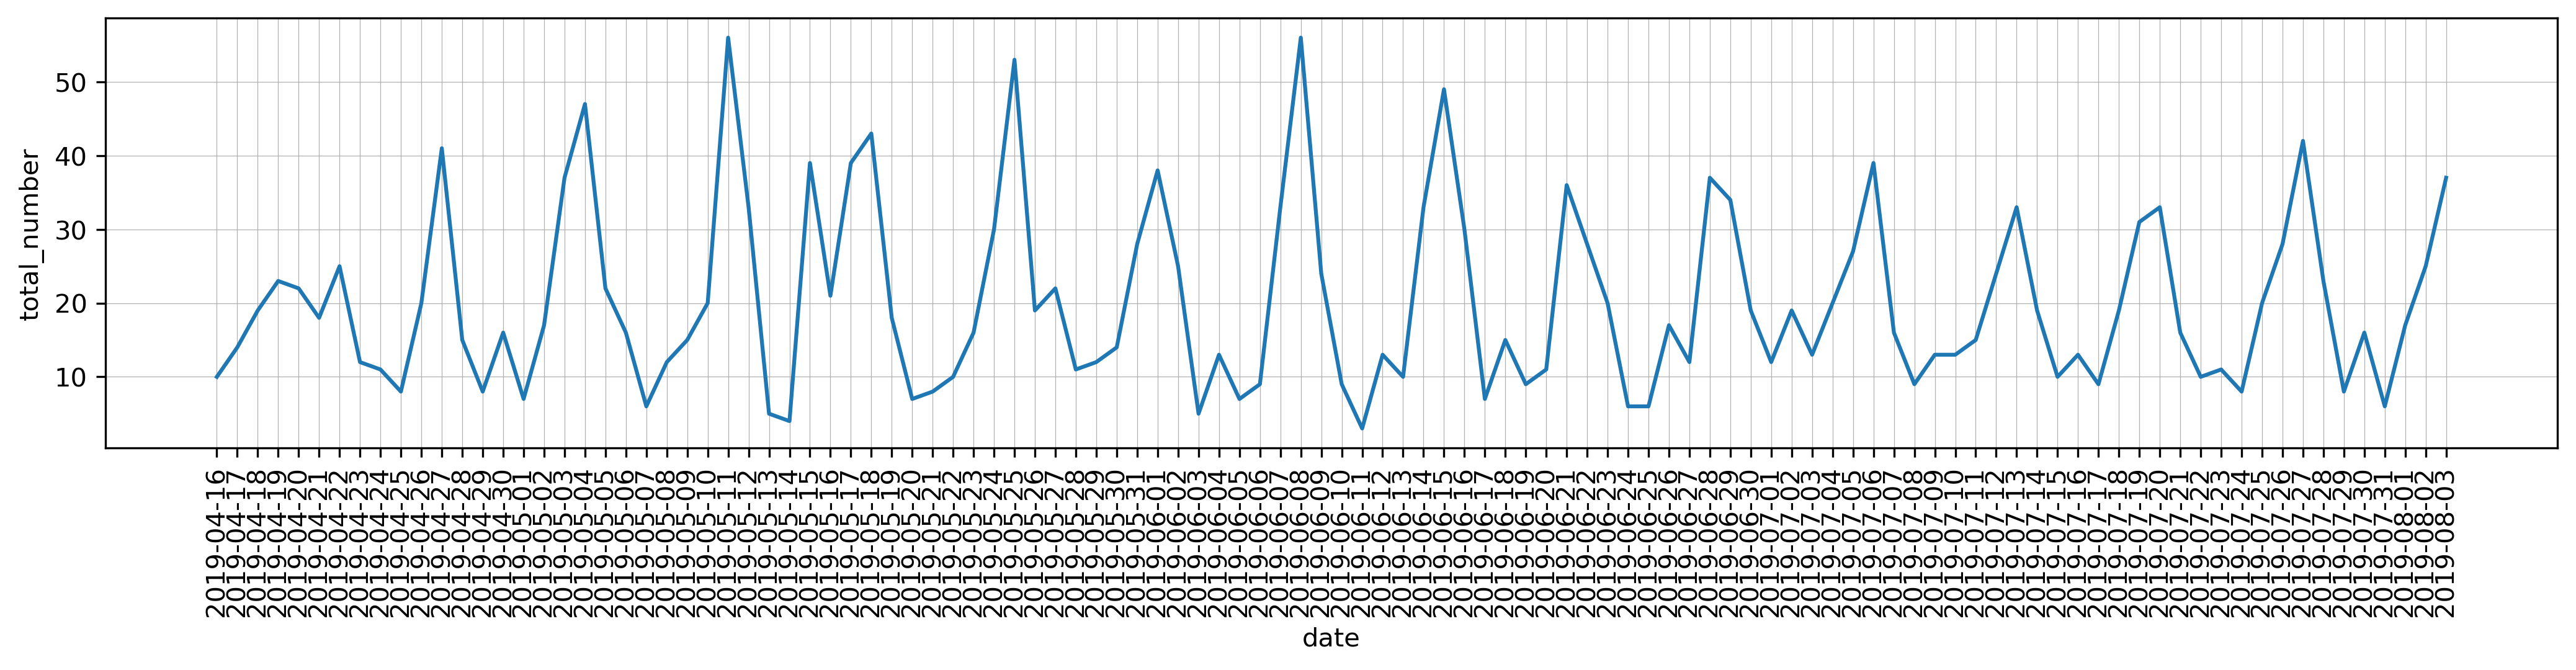

In [20]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=DailyOrders.tail(110), x='date', y='total_number')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [21]:
df = pd.DataFrame(DailyOrders)

In [22]:
# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

In [23]:
# Set 'date' column as the index
df.set_index('date', inplace=True)

In [24]:
# Reindex with a complete date range and fill missing values with zero
complete_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(complete_date_range)

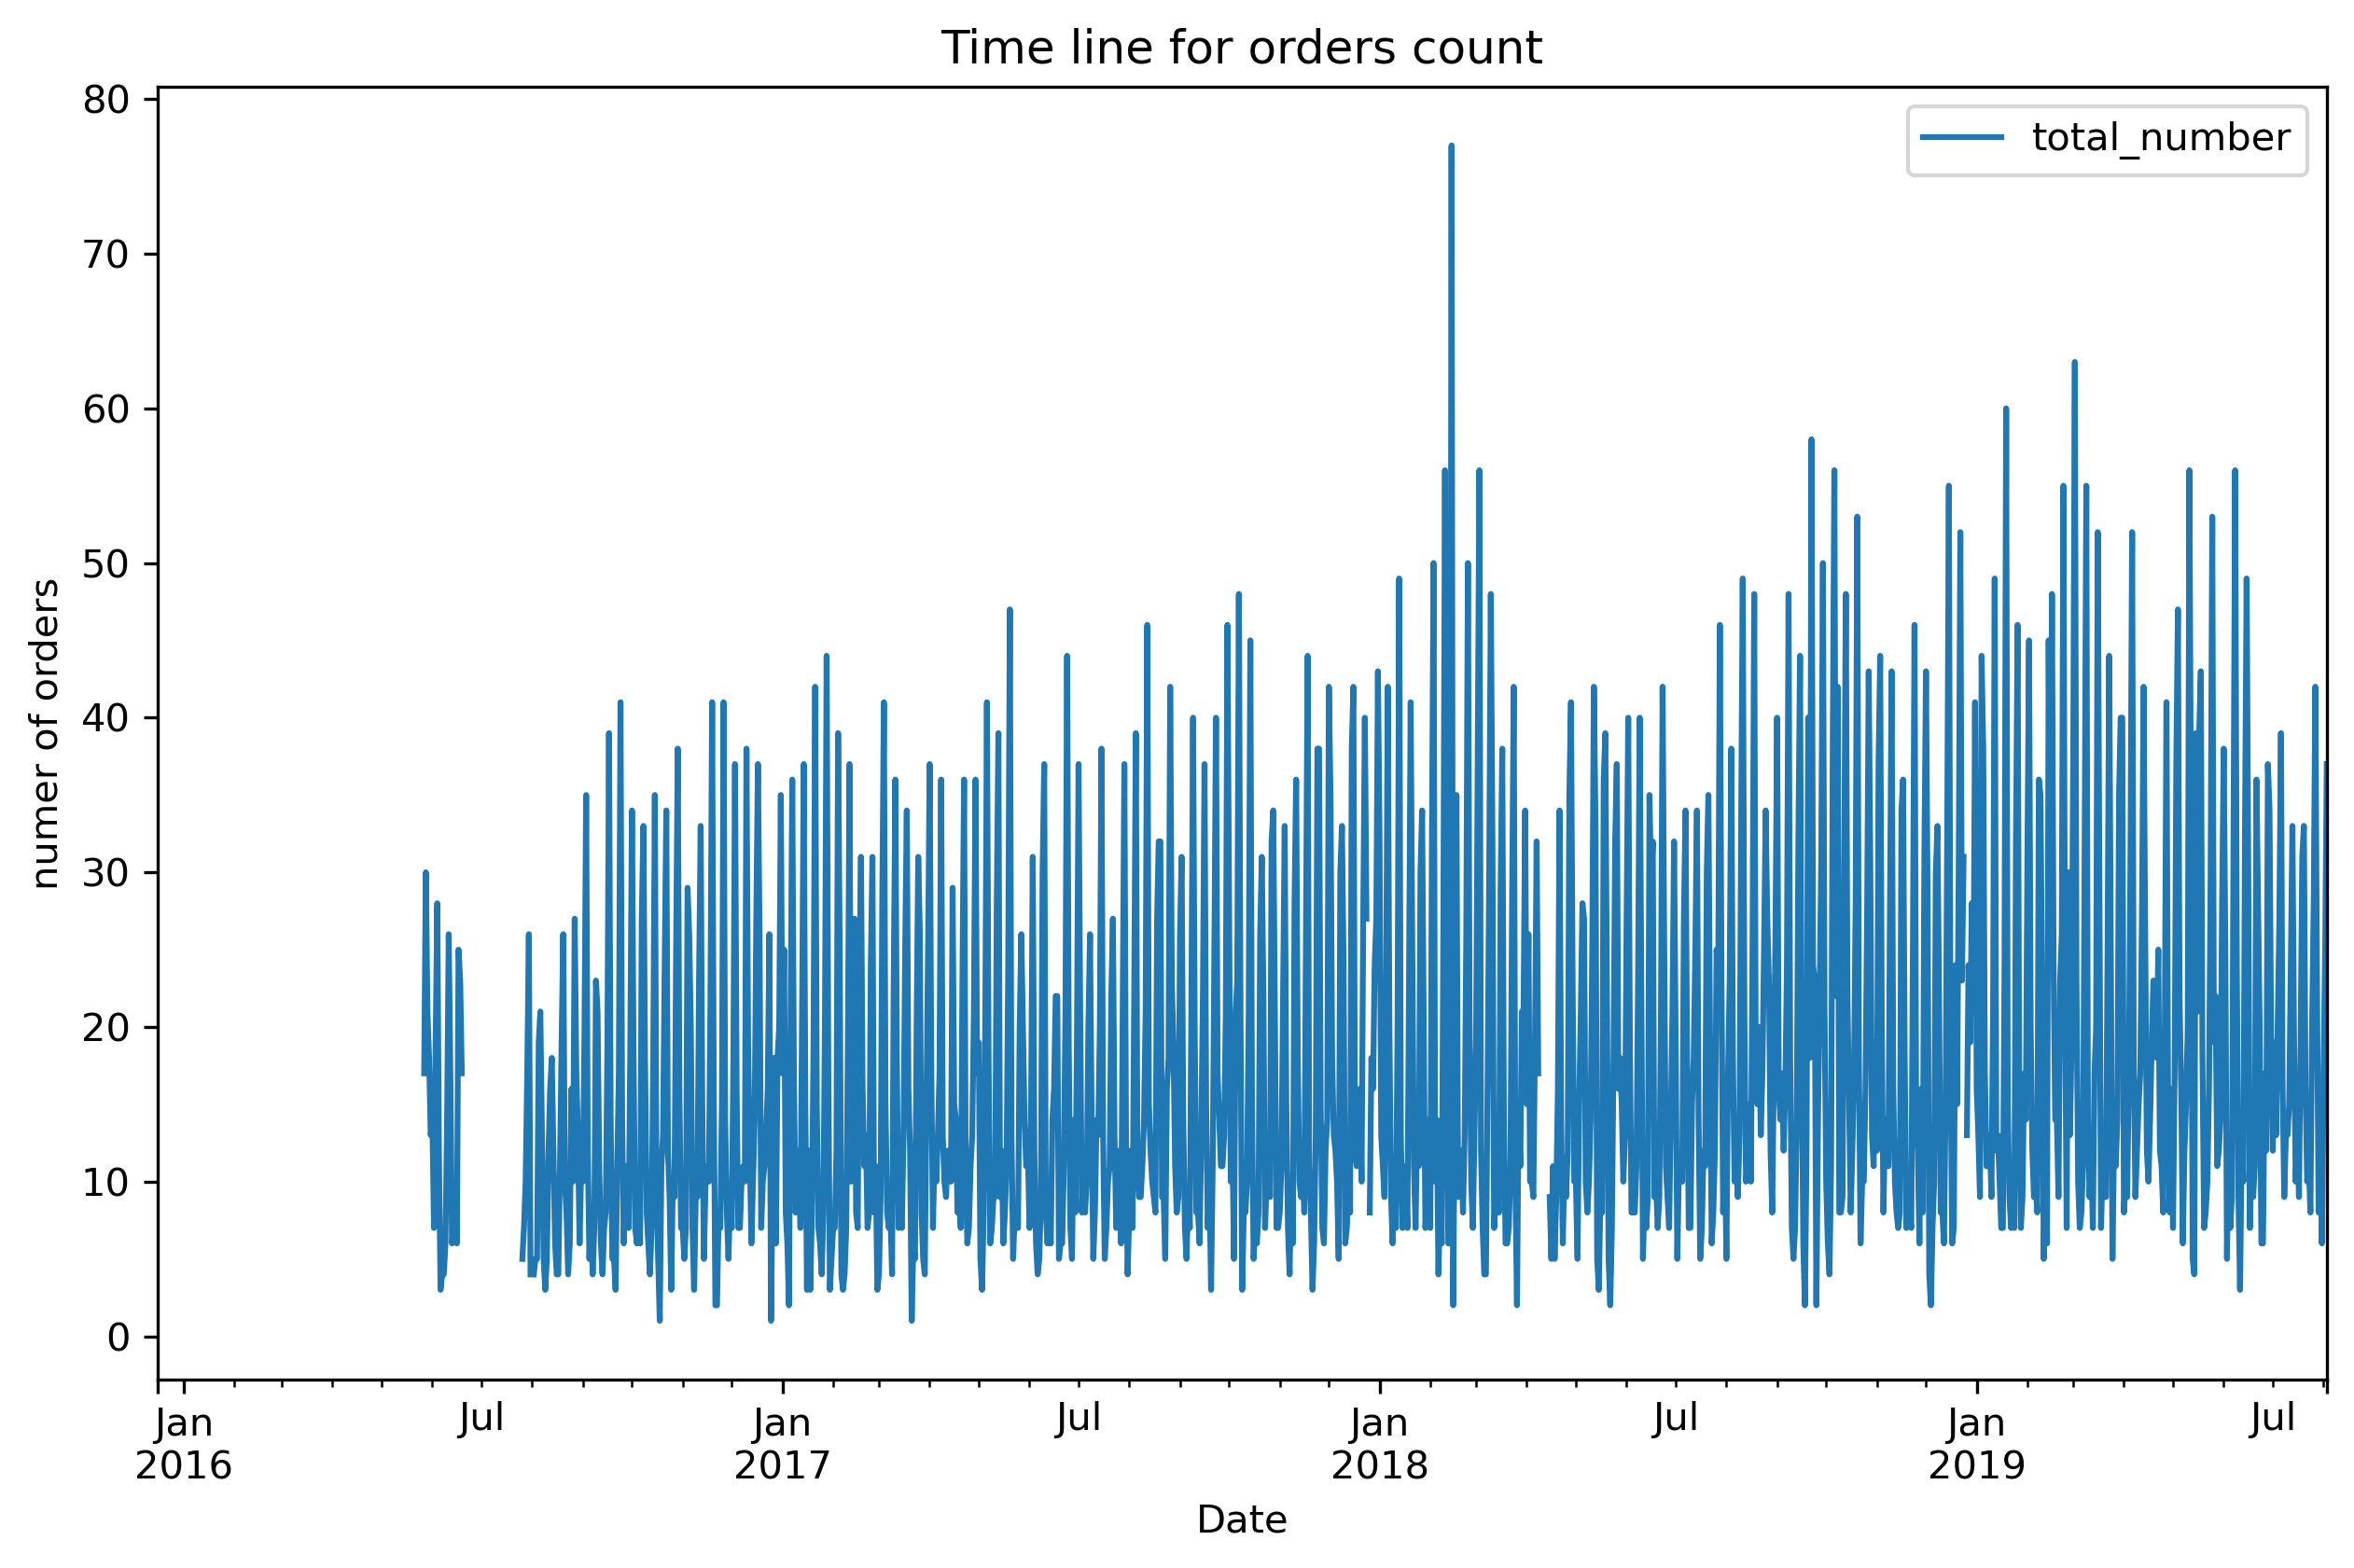

In [25]:
# Plot the chart
df.plot(y='total_number', linestyle='solid', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('numer of orders')
plt.title('Time line for orders count')
plt.show()

In [26]:
DailyOrders = df.reset_index(inplace = False)

In [27]:
DailyOrders.rename(columns={'index': 'date'}, inplace=True)

In [28]:
#filling missing values with zero
DailyOrders['total_number'].fillna(0, inplace=True);
#Clearly there is one outlier in 2019 somewhere, and also there are a lot of data points missing
#Getting the value of yesteday & filtering data because of there're some missing values
# we are going to get from greater than aug of 2016
DailyOrders['yesterday_number'] = DailyOrders['total_number'].shift(1)
DailyOrders['date'] = pd.to_datetime(DailyOrders['date'] ,dayfirst=True)
DailyOrders = DailyOrders.loc[DailyOrders['date'] > '2016-08-01']
DailyOrders['date'] = DailyOrders['date'].dt.date

In [29]:
print(DailyOrders.head())

           date  total_number  yesterday_number
230  2016-08-02           4.0               0.0
231  2016-08-03           5.0               4.0
232  2016-08-04           5.0               5.0
233  2016-08-05          19.0               5.0
234  2016-08-06          21.0              19.0


In [30]:
######## create a new column with the date value of the same day last week
from datetime import timedelta
DailyOrders['last_week_date'] = DailyOrders['date'] - timedelta(days=7)
DailyOrders['last_week_date'] = pd.to_datetime(DailyOrders['last_week_date'] ,dayfirst=True)
DailyOrders['last_week_date'] = DailyOrders['last_week_date'].dt.date
DailyOrders['last_week_value'] = DailyOrders.apply(lambda row: DailyOrders.loc[DailyOrders['date'] == row['last_week_date'], 'total_number'].iloc[0] 
                                                   if len(DailyOrders.loc[DailyOrders['date'] == row['last_week_date'], 'total_number']) > 0 else 0, axis=1)
print(DailyOrders.head())

           date  total_number  yesterday_number last_week_date  last_week_value
230  2016-08-02           4.0               0.0     2016-07-26              0.0
231  2016-08-03           5.0               4.0     2016-07-27              0.0
232  2016-08-04           5.0               5.0     2016-07-28              0.0
233  2016-08-05          19.0               5.0     2016-07-29              0.0
234  2016-08-06          21.0              19.0     2016-07-30              0.0


In [31]:
#getting the sum of the last week 
DailyOrders['last_week_sum'] = DailyOrders.apply(lambda row: DailyOrders.loc[(DailyOrders['date'] >= row['last_week_date']) & (DailyOrders['date'] < row['date']), 'total_number'].sum(), axis=1)

In [32]:
DailyOrders['date'] = pd.to_datetime(DailyOrders['date'] ,dayfirst=True)
print(DailyOrders.head())

          date  total_number  yesterday_number last_week_date  last_week_value  last_week_sum
230 2016-08-02           4.0               0.0     2016-07-26              0.0            0.0
231 2016-08-03           5.0               4.0     2016-07-27              0.0            4.0
232 2016-08-04           5.0               5.0     2016-07-28              0.0            9.0
233 2016-08-05          19.0               5.0     2016-07-29              0.0           14.0
234 2016-08-06          21.0              19.0     2016-07-30              0.0           33.0


In [33]:
#Set index
DailyOrders = DailyOrders.set_index('date');
DailyOrders.index = pd.to_datetime(DailyOrders.index)

In [34]:
#Spliting Data for Train and test 
train = DailyOrders.loc[DailyOrders.index <'2019-07-01']
test = DailyOrders.loc[DailyOrders.index >= '2019-07-01']

In [35]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek.astype(int)
    df['month'] = df.index.month.astype(int)
    df['year'] = df.index.year.astype(int)
    df['dayofyear'] = df.index.dayofyear.astype(int)
    df['dayofmonth'] = df.index.day.astype(int)
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    return df

In [36]:
df = create_features(DailyOrders)
train = create_features(train)
test = create_features(test)

In [37]:
print(df.head())

            total_number  yesterday_number last_week_date  last_week_value  last_week_sum  dayofweek  month  year  dayofyear  dayofmonth  weekofyear
date                                                                                                                                                
2016-08-02           4.0               0.0     2016-07-26              0.0            0.0          1      8  2016        215           2          31
2016-08-03           5.0               4.0     2016-07-27              0.0            4.0          2      8  2016        216           3          31
2016-08-04           5.0               5.0     2016-07-28              0.0            9.0          3      8  2016        217           4          31
2016-08-05          19.0               5.0     2016-07-29              0.0           14.0          4      8  2016        218           5          31
2016-08-06          21.0              19.0     2016-07-30              0.0           33.0          5      

In [38]:
FEATURES = ['yesterday_number','last_week_sum', 'last_week_value','dayofyear', 'weekofyear', 'dayofweek', 'month','year','dayofmonth']
TARGET = 'total_number'

In [39]:
X_old = df[FEATURES]
y_old = df[TARGET]

In [40]:
#############################LET's go inital model#############################
reg = xgb.XGBRegressor()

In [41]:
reg.fit(X_old, y_old , eval_set=[(X_old, y_old)])

[0]	validation_0-rmse:15.39944
[1]	validation_0-rmse:11.56202
[2]	validation_0-rmse:9.01320
[3]	validation_0-rmse:7.36172
[4]	validation_0-rmse:6.25255
[5]	validation_0-rmse:5.45691
[6]	validation_0-rmse:4.93129
[7]	validation_0-rmse:4.54697
[8]	validation_0-rmse:4.27706
[9]	validation_0-rmse:4.08099
[10]	validation_0-rmse:3.97502
[11]	validation_0-rmse:3.83469
[12]	validation_0-rmse:3.69987
[13]	validation_0-rmse:3.54799
[14]	validation_0-rmse:3.47955
[15]	validation_0-rmse:3.38995
[16]	validation_0-rmse:3.26511
[17]	validation_0-rmse:3.19402
[18]	validation_0-rmse:3.04930
[19]	validation_0-rmse:2.95347
[20]	validation_0-rmse:2.93679
[21]	validation_0-rmse:2.83179
[22]	validation_0-rmse:2.82570
[23]	validation_0-rmse:2.76240
[24]	validation_0-rmse:2.68611
[25]	validation_0-rmse:2.63784
[26]	validation_0-rmse:2.56459
[27]	validation_0-rmse:2.55468
[28]	validation_0-rmse:2.52424
[29]	validation_0-rmse:2.45343
[30]	validation_0-rmse:2.37628
[31]	validation_0-rmse:2.30947
[32]	validation_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [42]:
# get feature importance and ranking
important_values = reg.feature_importances_
sorted_idx = np.argsort(important_values)[::-1]
print(important_values)

[0.02007205 0.01705027 0.24004827 0.02761118 0.01731687 0.6150542
 0.         0.04375629 0.01909089]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

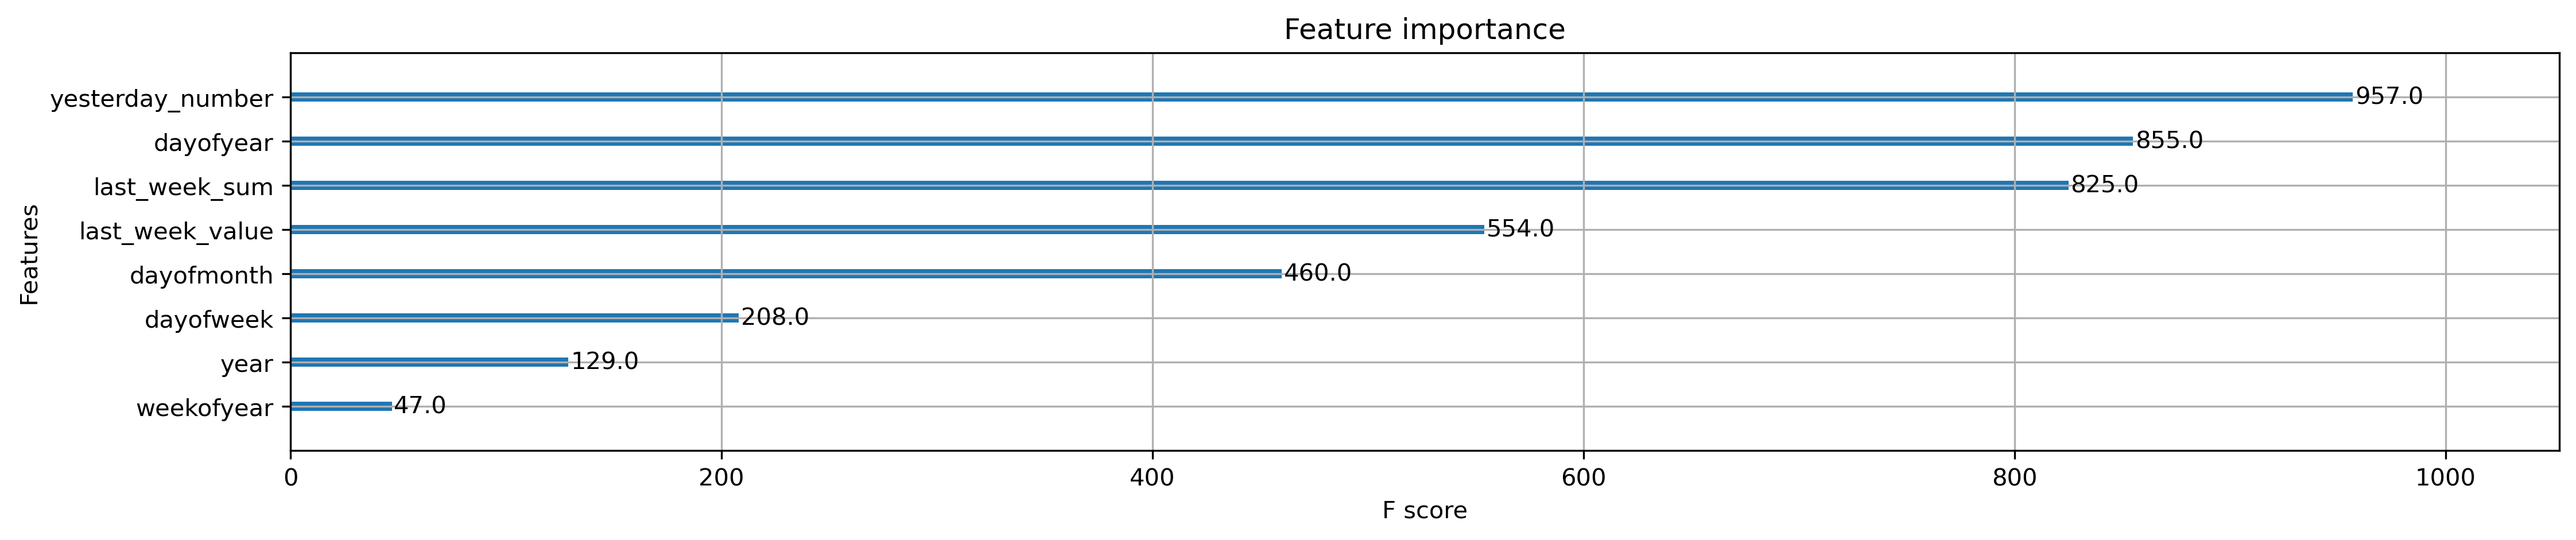

In [43]:
# Plot feature importance
xgb.plot_importance(reg)

In [44]:
# remove features with importance = 0
important_var_gain = [(X_old.columns[index], important_values[index]) for index in sorted_idx if important_values[index] > 0]
# we have 400 features with importance value>0
len(important_var_gain)

8

In [45]:
# restructure data and refit
important_varlist = [it[0] for it in important_var_gain]
print(important_varlist)

['dayofweek', 'last_week_value', 'year', 'dayofyear', 'yesterday_number', 'dayofmonth', 'weekofyear', 'last_week_sum']


###############################Splitting #####################################

In [46]:
X_train = train[important_varlist]
y_train = train[TARGET]

In [47]:
X_test = test[important_varlist]
y_test = test[TARGET]

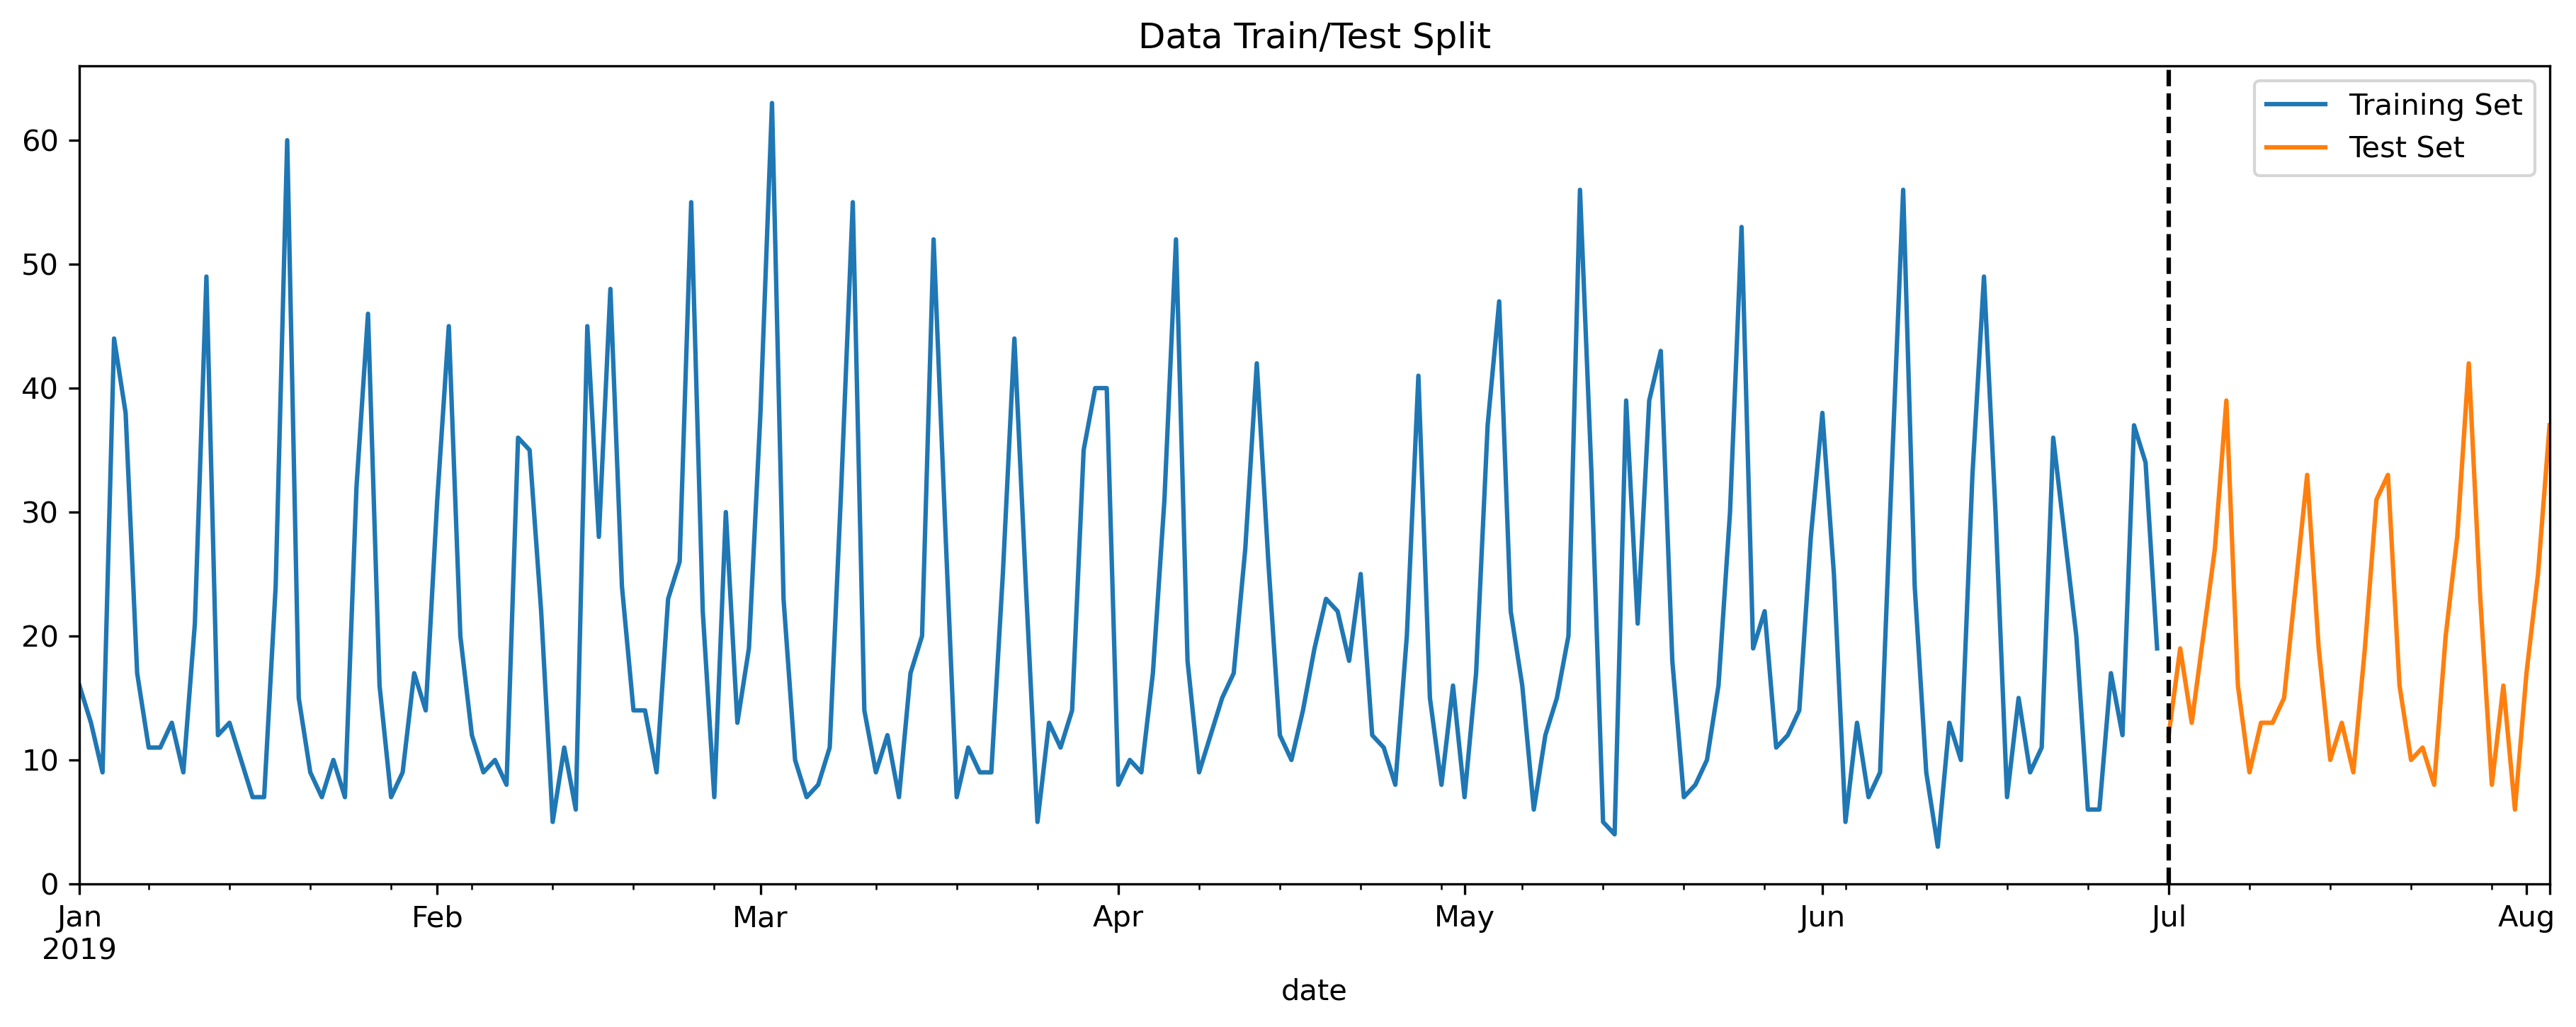

In [48]:
###Plotting 
fig, ax = plt.subplots(figsize=(15, 5))
pd.DataFrame(train[train.index >= '2019-01-01']).plot( y='total_number',ax=ax,label='Training Set', title='Data Train/Test Split',)
pd.DataFrame(test).plot( y='total_number',ax=ax ,label='Test Set')
ax.axvline('2019-07-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()       

In [49]:
print(test.shape)

(34, 11)


In [50]:
########################### RandomizedSearchCV ################################
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import uniform,randint

In [51]:
xgbreg = xgb.XGBRegressor(objective = 'reg:squarederror')
param_dist = {'n_estimators': randint(1000, 3000),
              'learning_rate': uniform(0.01, 0.06),
              'subsample': [0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
              'gamma' : [0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9],
              'colsample_bytree': [0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
              'min_child_weight': [1, 2, 3, 5, 7],
              'reg_alpha' : [0,1,2,3,4,5,6,7,8,9,10],
              'reg_lambda' : [0,1,2,3,4,5,6,7,8,9,10]
             }

verbose: integer
Controls the verbosity: the higher, the more messages.

In [52]:
regcv = RandomizedSearchCV(xgbreg, param_distributions = param_dist, 
    n_iter = 25, scoring = 'r2', cv = 3,
    error_score = 0, verbose = 10, n_jobs = -1)

In [53]:
search = regcv.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [54]:
search.best_params_

{'colsample_bytree': 0.99,
 'gamma': 0,
 'learning_rate': 0.016990609420865693,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 2141,
 'reg_alpha': 2,
 'reg_lambda': 3,
 'subsample': 0.5}

In [55]:
######################### Actual Model ########################################
reg = xgb.XGBRegressor(objective = 'reg:squarederror',
                  
                      learning_rate=0.010286668188327738,
                      gamma = 0 ,
                      reg_alpha= 10,  
                      reg_lambda= 4,
                      colsample_bytree= 0.85,
                      max_depth =  7,
                      min_child_weight = 1,
                      n_estimators= 1078,
                      booster='gbtree',
                      subsample = 0.7
 )

In [56]:
reg.fit(X_train, y_train, early_stopping_rounds=100, 
        eval_metric="mae", eval_set=[(X_test, y_test)])

[0]	validation_0-mae:18.54475
[1]	validation_0-mae:18.36557
[2]	validation_0-mae:18.18701
[3]	validation_0-mae:18.01585
[4]	validation_0-mae:17.84561
[5]	validation_0-mae:17.67473
[6]	validation_0-mae:17.50799
[7]	validation_0-mae:17.33371
[8]	validation_0-mae:17.17100
[9]	validation_0-mae:17.00907
[10]	validation_0-mae:16.84787
[11]	validation_0-mae:16.68833
[12]	validation_0-mae:16.52836
[13]	validation_0-mae:16.37290
[14]	validation_0-mae:16.21310
[15]	validation_0-mae:16.06008
[16]	validation_0-mae:15.90601
[17]	validation_0-mae:15.74957
[18]	validation_0-mae:15.59947
[19]	validation_0-mae:15.45020
[20]	validation_0-mae:15.30159
[21]	validation_0-mae:15.15786
[22]	validation_0-mae:15.01859
[23]	validation_0-mae:14.87593
[24]	validation_0-mae:14.73579
[25]	validation_0-mae:14.60130
[26]	validation_0-mae:14.45909
[27]	validation_0-mae:14.31638
[28]	validation_0-mae:14.17622
[29]	validation_0-mae:14.03984
[30]	validation_0-mae:13.89638
[31]	validation_0-mae:13.74660
[32]	validation_0-

C:\Users\LENOVO\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\LENOVO\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[54]	validation_0-mae:11.00167
[55]	validation_0-mae:10.89152
[56]	validation_0-mae:10.77342
[57]	validation_0-mae:10.66875
[58]	validation_0-mae:10.56818
[59]	validation_0-mae:10.47477
[60]	validation_0-mae:10.37807
[61]	validation_0-mae:10.27744
[62]	validation_0-mae:10.17888
[63]	validation_0-mae:10.08130
[64]	validation_0-mae:9.99135
[65]	validation_0-mae:9.88791
[66]	validation_0-mae:9.78543
[67]	validation_0-mae:9.68527
[68]	validation_0-mae:9.59850
[69]	validation_0-mae:9.50946
[70]	validation_0-mae:9.40950
[71]	validation_0-mae:9.32059
[72]	validation_0-mae:9.23585
[73]	validation_0-mae:9.14236
[74]	validation_0-mae:9.05564
[75]	validation_0-mae:8.97580
[76]	validation_0-mae:8.89008
[77]	validation_0-mae:8.80430
[78]	validation_0-mae:8.71835
[79]	validation_0-mae:8.63885
[80]	validation_0-mae:8.56483
[81]	validation_0-mae:8.48201
[82]	validation_0-mae:8.40479
[83]	validation_0-mae:8.32322
[84]	validation_0-mae:8.24149
[85]	validation_0-mae:8.16325
[86]	validation_0-mae:8.09954


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.85, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.010286668188327738,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1078, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [57]:
y_pred = reg.predict(X_test)

In [58]:
################## R2 score ##############################
#Calculate the R² score of the predictions on the testing data
r2_score = reg.score(X_test, y_test)
#Convert R² to percentage accuracy
percentage_accuracy = r2_score * 100
print("Percentage accuracy: {:.2f}%".format(percentage_accuracy))
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred)*100)
## 82%

Percentage accuracy: 81.59%
81.58882413581374


In [59]:
########### MSE ##############
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

MSE: 16.722316790969725


In [60]:
################ RMSE ############
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae) ## 20
print("RMSE" , np.sqrt(mse))

MAE: 3.3602991104125977
RMSE 4.089292945115295


In [61]:
########## MEAN #############
accuracy = 100 * (1 - mae/y_pred.mean())
print(f"The accuracy  MEAN of the XGBoost model is {accuracy:.2f}%");

The accuracy  MEAN of the XGBoost model is 81.10%


In [62]:
################## PLOTTING predicted vs actual #####################
test.reset_index(inplace = True)

In [63]:
new_df = test.copy();

In [64]:
y_pred = pd.Series(y_pred)
new_df['predicted'] = y_pred.values

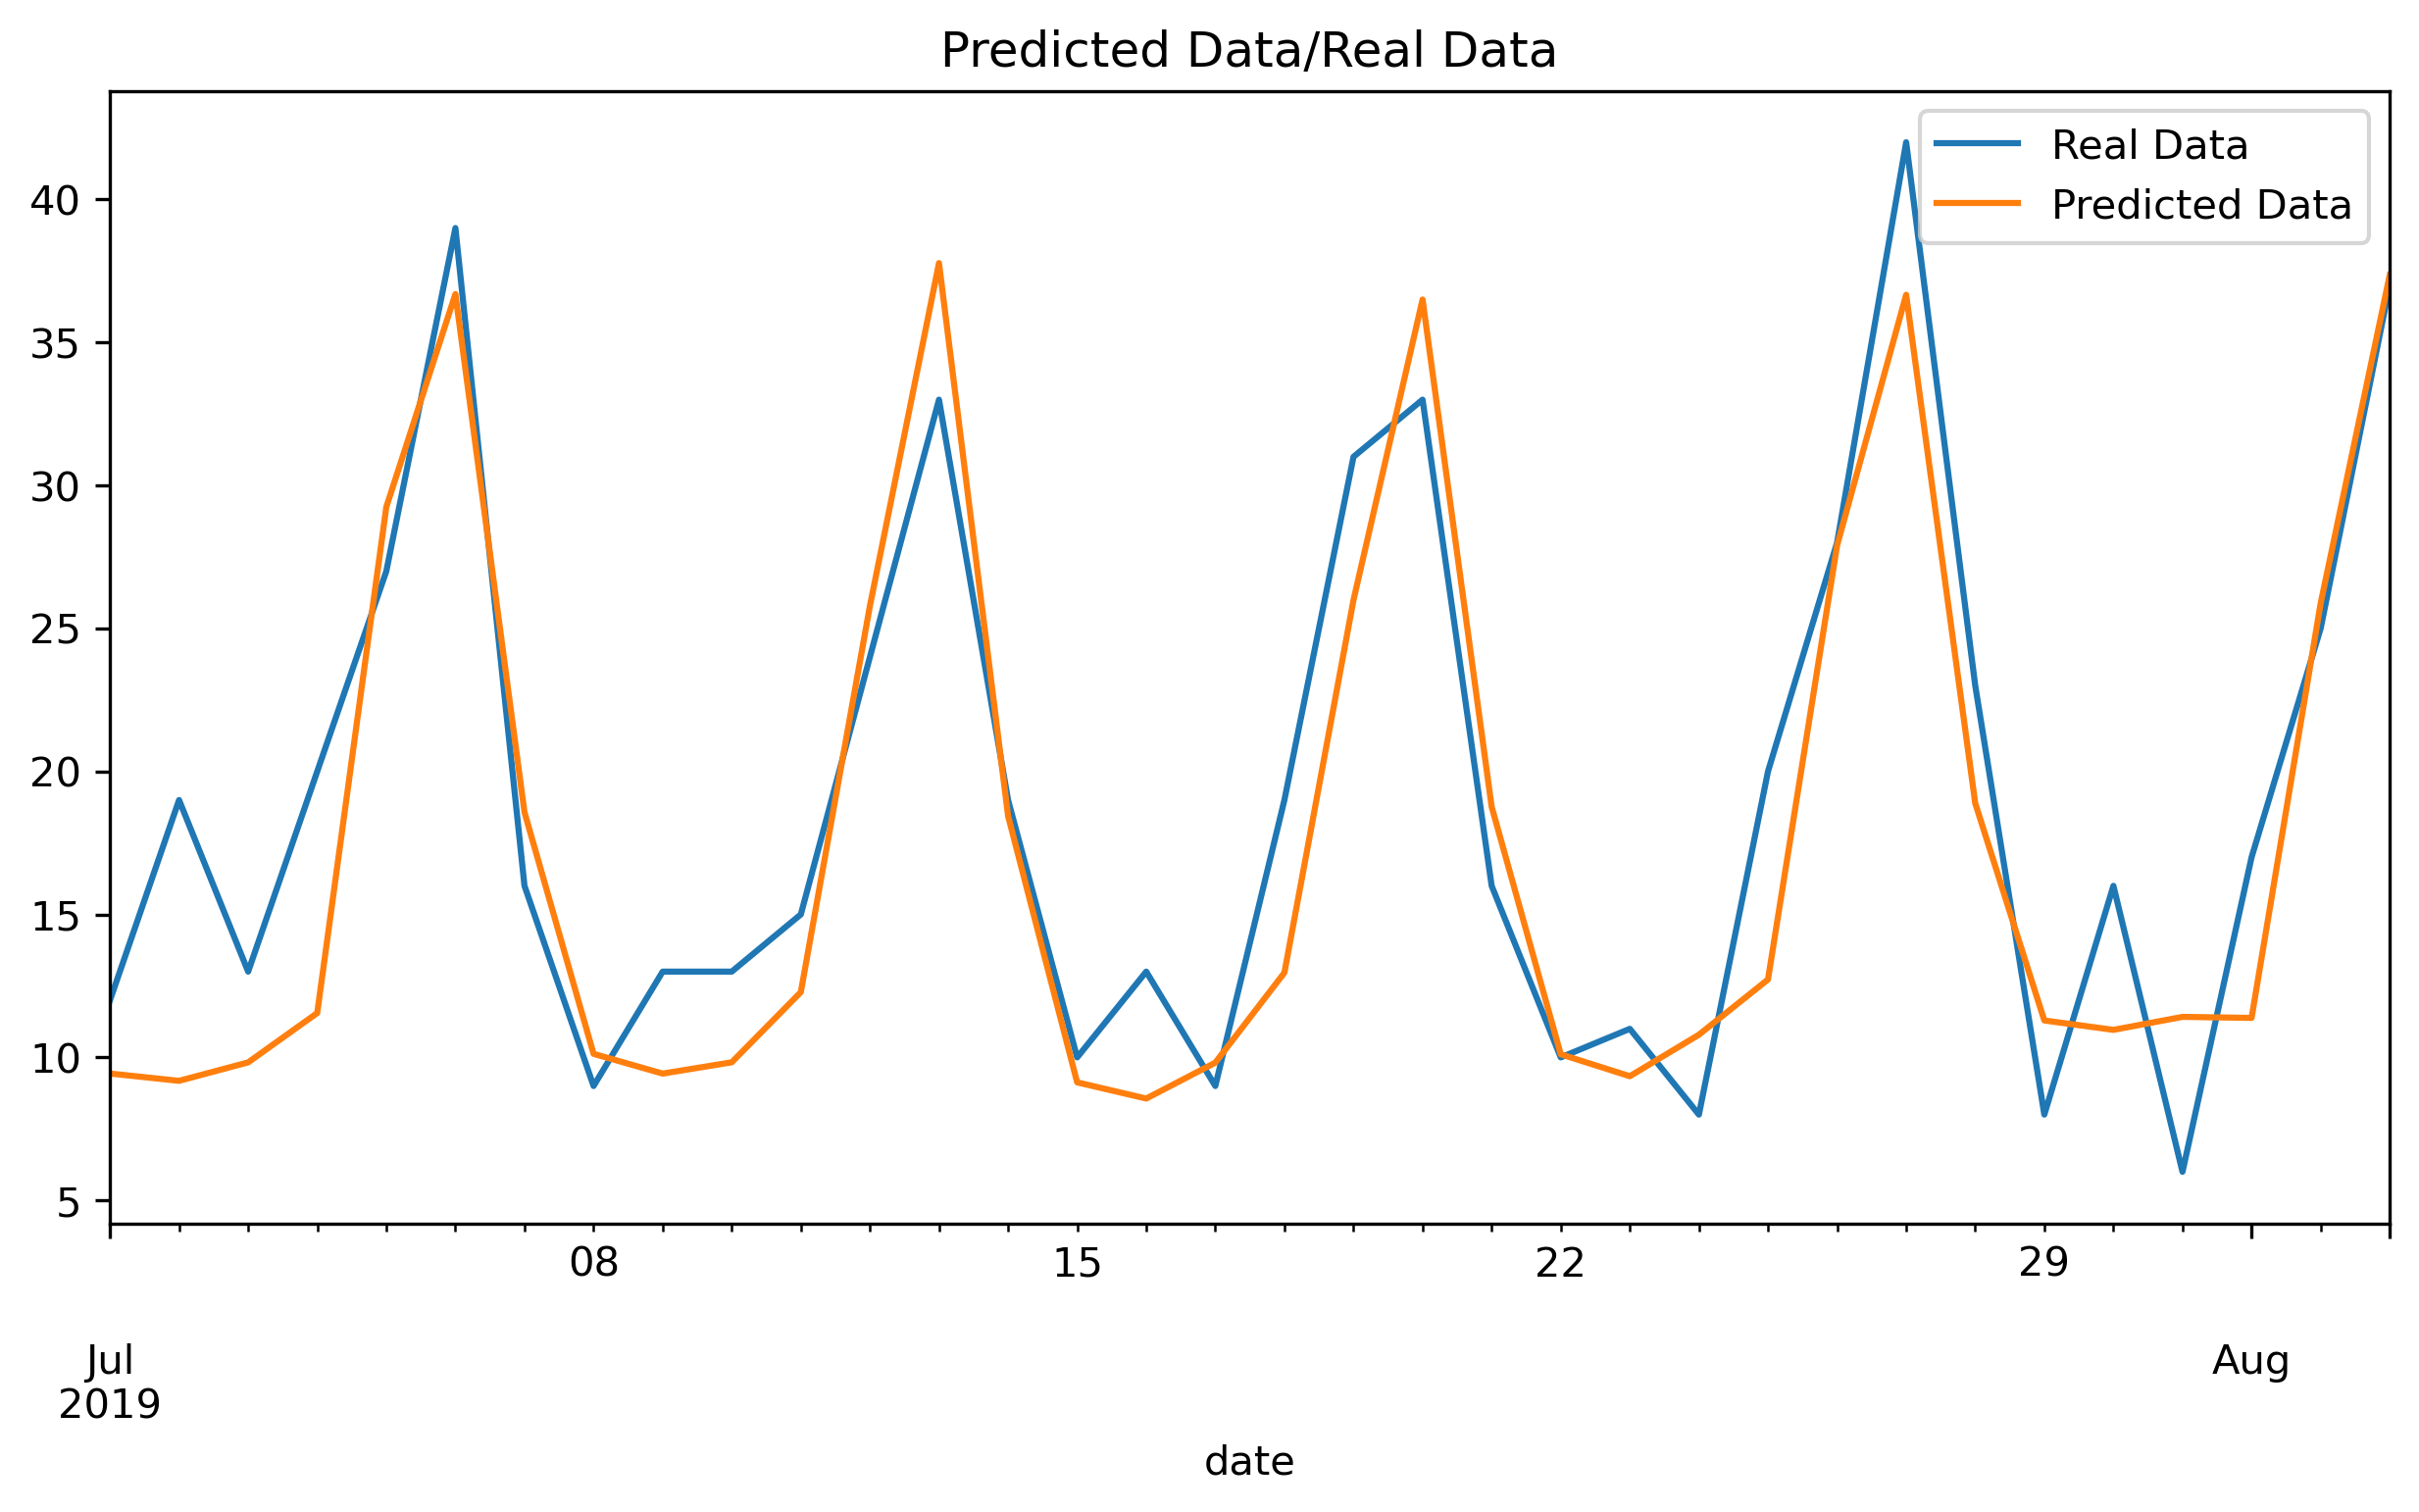

In [65]:
fig, ax = plt.subplots(figsize=(10, 5))
pd.DataFrame(test).plot(x='date', y = 'total_number',ax=ax,label='Real Data', title='Predicted Data/Real Data')
pd.DataFrame(new_df).plot(x='date', y = 'predicted',ax=ax ,label='Predicted')
ax.legend(['Real Data', 'Predicted Data'])
plt.show()   

In [66]:
import pickle
with open('orders.pkl', 'wb') as f:
    pickle.dump(reg, f)